# 02 — Concordance Analysis

Analyze concordance between FBA essentiality predictions and mutant growth
phenotypes for the 478 triple-covered genes in ADP1. All genes are
TnSeq-dispensable, so the key question is: **does FBA correctly predict
which dispensable genes have growth defects?**

1. Triple concordance matrix (FBA class × growth defect)
2. Growth as tie-breaker for FBA-TnSeq discordance
3. Condition-specific FBA flux vs growth rate correlations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')

triple = pd.read_csv(DATA_DIR / 'triple_gene_table.csv')
print(f'Loaded {len(triple)} triple-covered genes')
print(f'FBA classes: {triple["minimal_media_class"].value_counts().to_dict()}')
print(f'Growth defect: {triple["any_growth_defect"].sum()}/{len(triple)}')

Loaded 478 triple-covered genes
FBA classes: {'variable': 204, 'blocked': 196, 'essential': 78}
Growth defect: 343/478


## 1. FBA Class × Growth Defect Concordance

Cross-tabulate FBA class (essential/variable/blocked) with growth defect status.
If FBA is predictive, essential genes should show more growth defects and blocked
genes should show fewer.

In [2]:
# Contingency table: FBA class x growth defect
ct = pd.crosstab(
    triple['minimal_media_class'],
    triple['any_growth_defect'].map({True: 'Growth defect', False: 'Normal growth'}),
    margins=True
)
ct = ct.reindex(['essential', 'variable', 'blocked', 'All'])
print('FBA Class × Growth Defect Contingency Table:')
display(ct)

# Proportions
ct_prop = pd.crosstab(
    triple['minimal_media_class'],
    triple['any_growth_defect'].map({True: 'Growth defect', False: 'Normal growth'}),
    normalize='index'
) * 100
ct_prop = ct_prop.reindex(['essential', 'variable', 'blocked'])
print('\nGrowth defect rate by FBA class (%):')
display(ct_prop.round(1))

FBA Class × Growth Defect Contingency Table:


any_growth_defect,Growth defect,Normal growth,All
minimal_media_class,,,
essential,57,21,78
variable,150,54,204
blocked,136,60,196
All,343,135,478



Growth defect rate by FBA class (%):


any_growth_defect,Growth defect,Normal growth
minimal_media_class,,
essential,73.1,26.9
variable,73.5,26.5
blocked,69.4,30.6


In [3]:
# Chi-squared test: is FBA class associated with growth defect?
ct_no_margins = pd.crosstab(
    triple['minimal_media_class'],
    triple['any_growth_defect']
)
chi2, p_value, dof, expected = stats.chi2_contingency(ct_no_margins)
print(f'Chi-squared test: chi2={chi2:.2f}, p={p_value:.4f}, dof={dof}')

# Concordance rate: FBA-essential genes with defects + FBA-blocked without defects
concordant = (
    ((triple['minimal_media_class'] == 'essential') & triple['any_growth_defect']).sum() +
    ((triple['minimal_media_class'] == 'blocked') & ~triple['any_growth_defect']).sum()
)
total_ess_blocked = ((triple['minimal_media_class'] == 'essential') |
                     (triple['minimal_media_class'] == 'blocked')).sum()
print(f'\nFBA concordance (essential+defect or blocked+normal): '
      f'{concordant}/{total_ess_blocked} ({concordant/total_ess_blocked*100:.1f}%)')

Chi-squared test: chi2=0.93, p=0.6293, dof=2

FBA concordance (essential+defect or blocked+normal): 117/274 (42.7%)


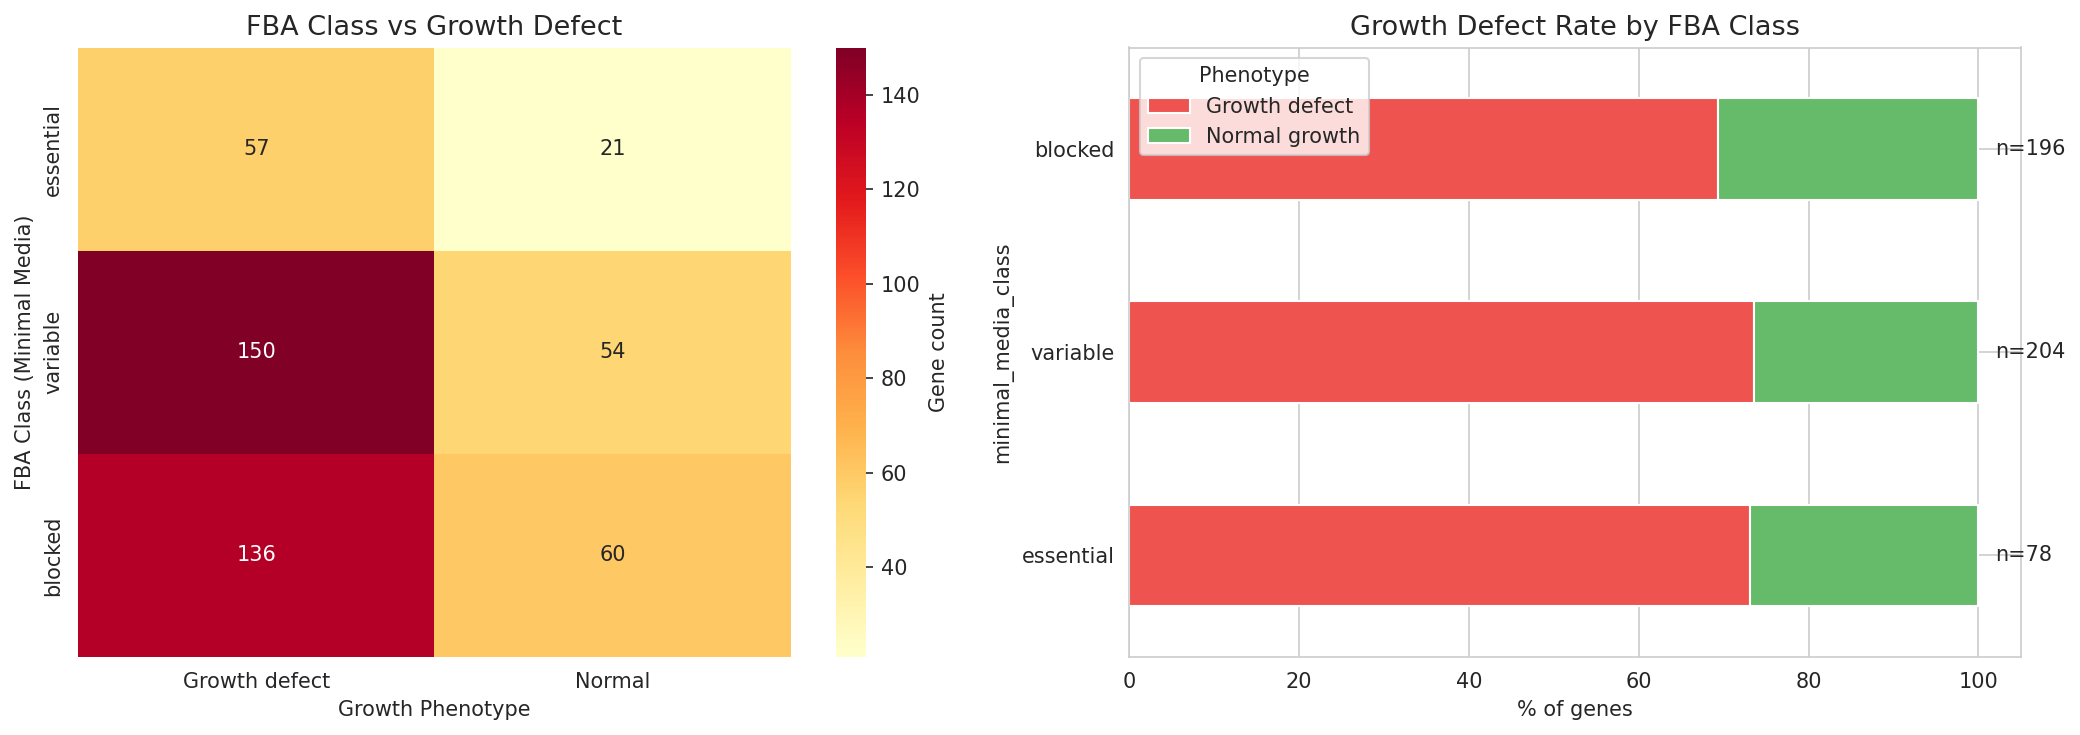

In [4]:
# Visualization: concordance heatmap and bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Heatmap
ct_plot = pd.crosstab(
    triple['minimal_media_class'],
    triple['any_growth_defect'].map({True: 'Growth defect', False: 'Normal'})
).reindex(['essential', 'variable', 'blocked'])
sns.heatmap(ct_plot, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0],
            cbar_kws={'label': 'Gene count'})
axes[0].set_title('FBA Class vs Growth Defect', fontsize=13)
axes[0].set_ylabel('FBA Class (Minimal Media)')
axes[0].set_xlabel('Growth Phenotype')

# Panel 2: Stacked bar showing defect rate per FBA class
ct_prop_plot = ct_prop.reindex(['essential', 'variable', 'blocked'])
ct_prop_plot.plot(kind='barh', stacked=True, ax=axes[1],
                  color=['#EF5350', '#66BB6A'])
axes[1].set_title('Growth Defect Rate by FBA Class', fontsize=13)
axes[1].set_xlabel('% of genes')
axes[1].legend(title='Phenotype')
# Add count annotations
for i, fba_class in enumerate(['essential', 'variable', 'blocked']):
    n = (triple['minimal_media_class'] == fba_class).sum()
    axes[1].text(102, i, f'n={n}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fba_growth_concordance.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Growth as Tie-Breaker for FBA-TnSeq Discordance

The prior project found 74% FBA-TnSeq concordance. Here, since all 478 genes
are TnSeq-dispensable, the FBA-TnSeq "discordant" genes are those FBA calls
essential (78 genes). Do these genes' mutants actually show growth defects?

- **FBA-essential/TnSeq-dispensable** (78 genes): FBA says gene is essential.
  If mutants show growth defects → FBA is partially right (gene matters, just not lethal).
- **FBA-blocked/TnSeq-dispensable** (196 genes): FBA says zero flux.
  If mutants grow normally → FBA and TnSeq agree (gene doesn't matter).
- **FBA-variable/TnSeq-dispensable** (204 genes): FBA says nonzero flux, not essential.
  Could go either way.

/tmp/ipykernel_7180/2975607849.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=triple, x='minimal_media_class', y='mean_growth',


/tmp/ipykernel_7180/2975607849.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=triple, x='minimal_media_class', y='mutant_growth_glucose',


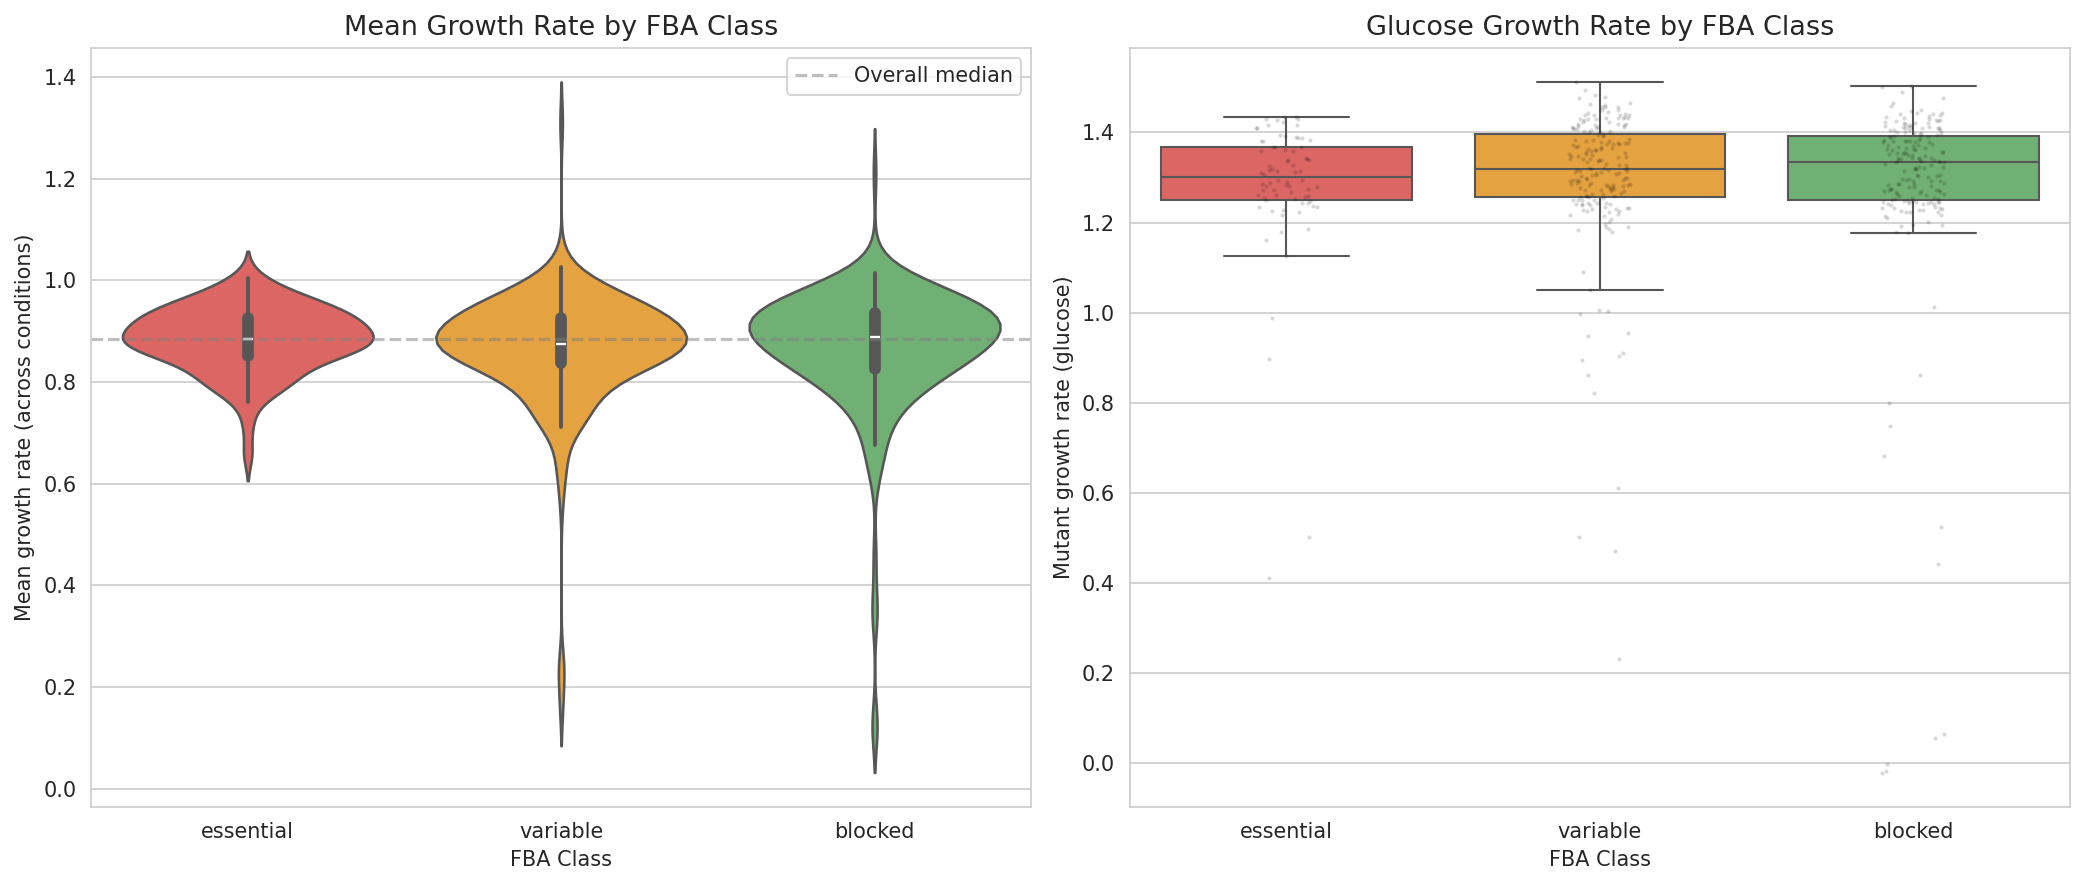

In [5]:
# Growth rate distributions by FBA class
growth_cols = [c for c in triple.columns if c.startswith('mutant_growth_')]
condition_names = [c.replace('mutant_growth_', '') for c in growth_cols]

# Compute mean growth rate across all conditions for each gene
triple['mean_growth'] = triple[growth_cols].mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Violin plot of mean growth by FBA class
order = ['essential', 'variable', 'blocked']
palette = {'essential': '#EF5350', 'variable': '#FFA726', 'blocked': '#66BB6A'}
sns.violinplot(data=triple, x='minimal_media_class', y='mean_growth',
               order=order, palette=palette, ax=axes[0], inner='box')
axes[0].set_title('Mean Growth Rate by FBA Class', fontsize=13)
axes[0].set_xlabel('FBA Class')
axes[0].set_ylabel('Mean growth rate (across conditions)')
axes[0].axhline(y=triple['mean_growth'].median(), color='gray',
                linestyle='--', alpha=0.5, label='Overall median')
axes[0].legend()

# Panel 2: Box plot of growth rate per condition, faceted by FBA class
# Use glucose as representative condition
sns.boxplot(data=triple, x='minimal_media_class', y='mutant_growth_glucose',
            order=order, palette=palette, ax=axes[1], showfliers=False)
sns.stripplot(data=triple, x='minimal_media_class', y='mutant_growth_glucose',
              order=order, color='black', alpha=0.15, size=2, ax=axes[1])
axes[1].set_title('Glucose Growth Rate by FBA Class', fontsize=13)
axes[1].set_xlabel('FBA Class')
axes[1].set_ylabel('Mutant growth rate (glucose)')

plt.tight_layout()
plt.savefig(FIG_DIR / 'growth_by_fba_class.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Kruskal-Wallis test: growth rate differs by FBA class?
groups = [triple.loc[triple['minimal_media_class'] == c, 'mean_growth'].dropna()
          for c in order]
kw_stat, kw_p = stats.kruskal(*groups)
print(f'Kruskal-Wallis test (mean growth ~ FBA class): H={kw_stat:.2f}, p={kw_p:.4f}')

# Pairwise Mann-Whitney U tests
print('\nPairwise Mann-Whitney U tests:')
for i, c1 in enumerate(order):
    for c2 in order[i+1:]:
        g1 = triple.loc[triple['minimal_media_class'] == c1, 'mean_growth'].dropna()
        g2 = triple.loc[triple['minimal_media_class'] == c2, 'mean_growth'].dropna()
        u_stat, u_p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
        print(f'  {c1} vs {c2}: U={u_stat:.0f}, p={u_p:.4f} '
              f'(median {g1.median():.3f} vs {g2.median():.3f})')

# Per-condition comparison
print('\nGrowth defect rate by FBA class, per condition:')
for cond in condition_names:
    col = f'growth_defect_{cond}'
    rates = {}
    for fba_class in order:
        mask = triple['minimal_media_class'] == fba_class
        n_defect = triple.loc[mask, col].sum()
        n_total = triple.loc[mask, col].notna().sum()
        rates[fba_class] = f'{n_defect}/{n_total}' if n_total > 0 else 'N/A'
    print(f'  {cond:>12}: essential={rates["essential"]:>8}  '
          f'variable={rates["variable"]:>8}  blocked={rates["blocked"]:>8}')

Kruskal-Wallis test (mean growth ~ FBA class): H=1.67, p=0.4343

Pairwise Mann-Whitney U tests:
  essential vs variable: U=8648, p=0.2590 (median 0.885 vs 0.876)
  essential vs blocked: U=7696, p=0.9307 (median 0.885 vs 0.889)
  variable vs blocked: U=18777, p=0.2934 (median 0.876 vs 0.889)

Growth defect rate by FBA class, per condition:
       acetate: essential=   22/74  variable=  50/195  blocked=  42/187
    asparagine: essential=   17/77  variable=  61/199  blocked=  39/192
    butanediol: essential=   11/77  variable=  53/198  blocked=  53/191
     glucarate: essential=   20/77  variable=  47/192  blocked=  45/180
       glucose: essential=   20/76  variable=  48/195  blocked=  47/188
       lactate: essential=   13/77  variable=  59/198  blocked=  45/194
       quinate: essential=   12/77  variable=  54/196  blocked=  50/191
          urea: essential=   26/77  variable=  41/201  blocked=  50/190


In [7]:
# Tie-breaker analysis: for FBA-essential/TnSeq-dispensable genes,
# does growth support FBA's prediction?
fba_ess = triple[triple['minimal_media_class'] == 'essential'].copy()
fba_var = triple[triple['minimal_media_class'] == 'variable'].copy()
fba_blk = triple[triple['minimal_media_class'] == 'blocked'].copy()

print('Tie-breaker summary:')
print(f'\n  FBA-essential (n={len(fba_ess)}):')
print(f'    Growth defect: {fba_ess["any_growth_defect"].sum()} '
      f'({fba_ess["any_growth_defect"].mean()*100:.0f}%) — growth supports FBA')
print(f'    Normal growth: {(~fba_ess["any_growth_defect"]).sum()} '
      f'({(~fba_ess["any_growth_defect"]).mean()*100:.0f}%) — FBA over-predicts')

print(f'\n  FBA-variable (n={len(fba_var)}):')
print(f'    Growth defect: {fba_var["any_growth_defect"].sum()} '
      f'({fba_var["any_growth_defect"].mean()*100:.0f}%)')
print(f'    Normal growth: {(~fba_var["any_growth_defect"]).sum()} '
      f'({(~fba_var["any_growth_defect"]).mean()*100:.0f}%)')

print(f'\n  FBA-blocked (n={len(fba_blk)}):')
print(f'    Growth defect: {fba_blk["any_growth_defect"].sum()} '
      f'({fba_blk["any_growth_defect"].mean()*100:.0f}%) — FBA under-predicts')
print(f'    Normal growth: {(~fba_blk["any_growth_defect"]).sum()} '
      f'({(~fba_blk["any_growth_defect"]).mean()*100:.0f}%) — growth supports FBA')

Tie-breaker summary:

  FBA-essential (n=78):
    Growth defect: 57 (73%) — growth supports FBA
    Normal growth: 21 (27%) — FBA over-predicts

  FBA-variable (n=204):
    Growth defect: 150 (74%)
    Normal growth: 54 (26%)

  FBA-blocked (n=196):
    Growth defect: 136 (69%) — FBA under-predicts
    Normal growth: 60 (31%) — growth supports FBA


## 2b. Growth Defect Threshold Sensitivity Analysis

The Q25 threshold is arbitrary. Test whether the null result (no FBA-growth association)
holds across a range of thresholds (Q10 through Q40) and per-condition.

In [8]:
# Sensitivity analysis: test multiple thresholds
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
sensitivity_results = []

for q_thresh in thresholds:
    # Recompute "any growth defect" at this threshold
    defect_flags = pd.DataFrame()
    for col, cond in zip(growth_cols, condition_names):
        vals = triple[col]
        cutoff = vals.dropna().quantile(q_thresh)
        defect = pd.array(vals < cutoff, dtype=pd.BooleanDtype())
        defect[vals.isna()] = pd.NA
        defect_flags[cond] = defect

    any_defect = defect_flags.any(axis=1).fillna(False).astype(bool)
    n_defect = any_defect.sum()

    # Chi-squared test at this threshold
    ct_test = pd.crosstab(triple['minimal_media_class'], any_defect)
    chi2_t, p_t, _, _ = stats.chi2_contingency(ct_test)

    # Defect rates by FBA class
    rates = {}
    for c in ['essential', 'variable', 'blocked']:
        mask = triple['minimal_media_class'] == c
        rates[c] = any_defect[mask].mean() * 100

    sensitivity_results.append({
        'threshold': f'Q{int(q_thresh*100)}',
        'n_defect': n_defect,
        'pct_defect': n_defect / len(triple) * 100,
        'essential_rate': rates['essential'],
        'variable_rate': rates['variable'],
        'blocked_rate': rates['blocked'],
        'chi2': chi2_t,
        'p_value': p_t,
    })

sens_df = pd.DataFrame(sensitivity_results)
print('Threshold sensitivity analysis:')
display(sens_df.round(3))

# Also test continuous approach: Kruskal-Wallis on mean growth rate
# (threshold-independent)
print(f'\nThreshold-independent test (continuous mean growth rate):')
print(f'  Kruskal-Wallis H={kw_stat:.2f}, p={kw_p:.4f}')

Threshold sensitivity analysis:


,threshold,n_defect,pct_defect,essential_rate,variable_rate,blocked_rate,chi2,p_value
0,Q10,197,41.213,41.026,41.667,40.816,0.031,0.985
1,Q15,268,56.067,55.128,57.353,55.102,0.239,0.887
2,Q20,311,65.063,65.385,68.137,61.735,1.807,0.405
3,Q25,343,71.757,73.077,73.529,69.388,0.926,0.629
4,Q30,368,76.987,79.487,79.412,73.469,2.321,0.313
5,Q35,390,81.590,84.615,85.294,76.531,5.679,0.058
6,Q40,408,85.356,89.744,88.235,80.612,6.083,0.048



Threshold-independent test (continuous mean growth rate):
  Kruskal-Wallis H=1.67, p=0.4343


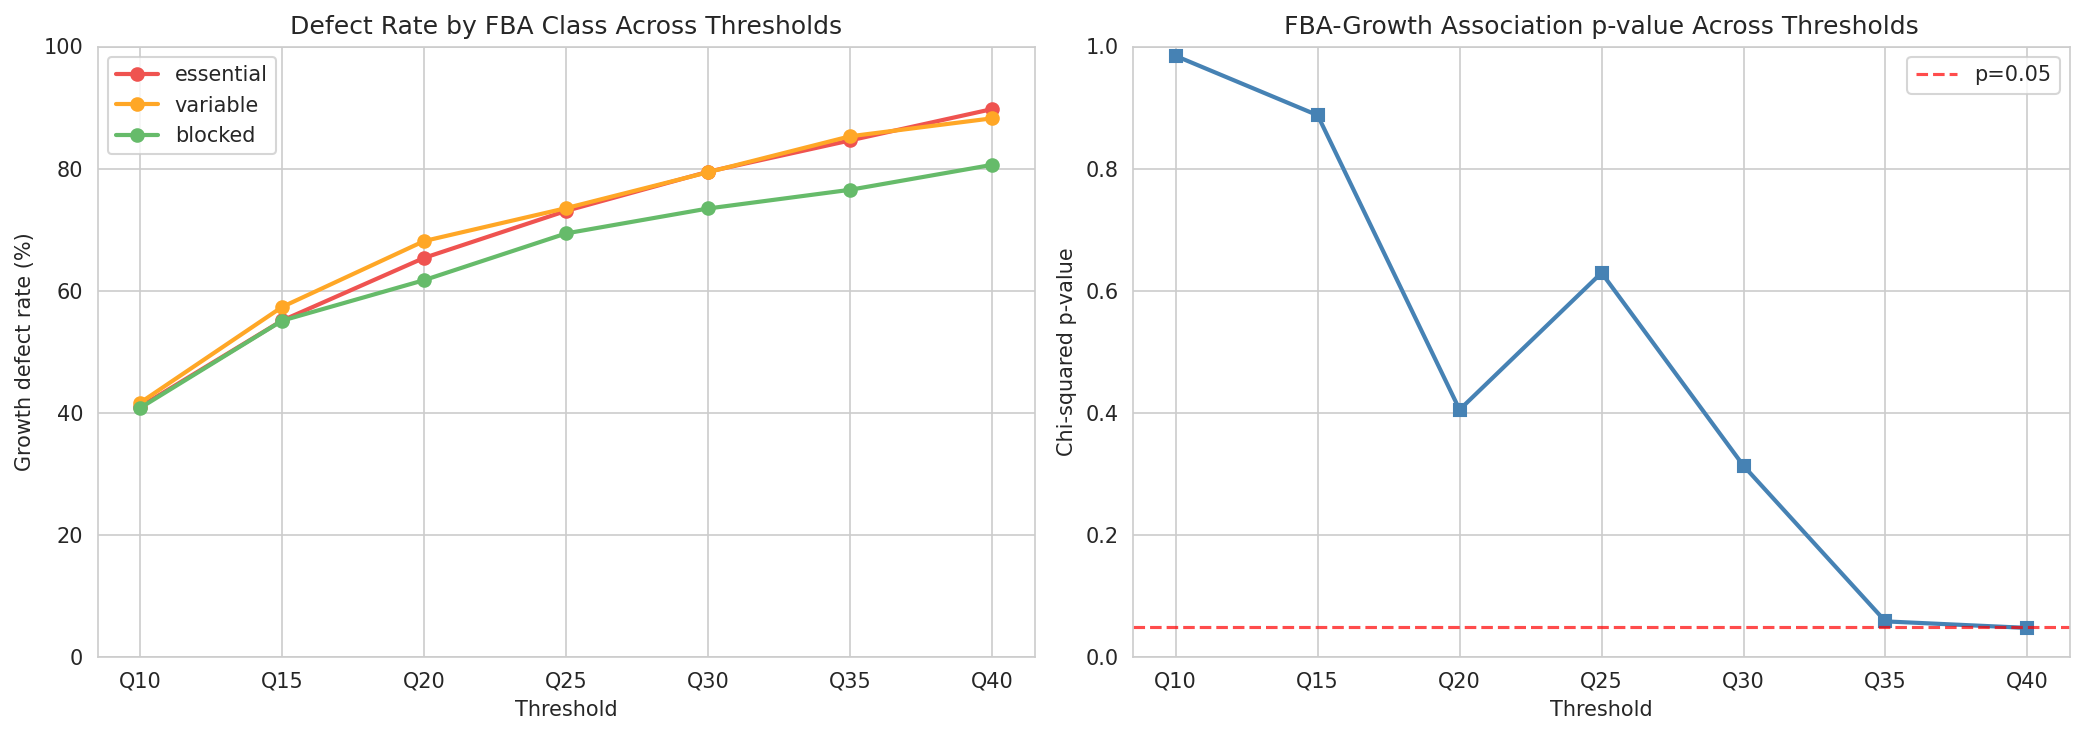

The null result holds across all thresholds: minimum p = 0.0478 (at Q40)


In [9]:
# Visualization: sensitivity analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Defect rate by FBA class across thresholds
for c, color in [('essential', '#EF5350'), ('variable', '#FFA726'), ('blocked', '#66BB6A')]:
    axes[0].plot(sens_df['threshold'], sens_df[f'{c}_rate'],
                 marker='o', color=color, label=c, linewidth=2)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Growth defect rate (%)')
axes[0].set_title('Defect Rate by FBA Class Across Thresholds', fontsize=12)
axes[0].legend()
axes[0].set_ylim(0, 100)

# Panel 2: Chi-squared p-value across thresholds
axes[1].plot(sens_df['threshold'], sens_df['p_value'],
             marker='s', color='steelblue', linewidth=2)
axes[1].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='p=0.05')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Chi-squared p-value')
axes[1].set_title('FBA-Growth Association p-value Across Thresholds', fontsize=12)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIG_DIR / 'threshold_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'The null result holds across all thresholds: '
      f'minimum p = {sens_df["p_value"].min():.4f} (at {sens_df.loc[sens_df["p_value"].idxmin(), "threshold"]})')

## 3. Condition-Specific FBA Flux vs Growth Rate

For the 6 conditions with matched FBA flux predictions, compare flux magnitudes
with measured growth rates. Higher FBA flux should correlate with larger growth
effects (lower flux → more essential → worse growth when deleted).

In [10]:
# Condition-specific correlations
matched_conditions = ['glucose', 'acetate', 'asparagine', 'butanediol', 'glucarate', 'lactate']

corr_results = []
for cond in matched_conditions:
    flux_col = f'fba_flux_{cond}'
    growth_col = f'mutant_growth_{cond}'

    # Only use genes with both measurements
    mask = triple[flux_col].notna() & triple[growth_col].notna()
    n = mask.sum()
    if n > 10:
        rho, p = stats.spearmanr(triple.loc[mask, flux_col],
                                  triple.loc[mask, growth_col])
        corr_results.append({
            'condition': cond,
            'n_genes': n,
            'spearman_rho': rho,
            'p_value': p
        })
    else:
        corr_results.append({
            'condition': cond,
            'n_genes': n,
            'spearman_rho': np.nan,
            'p_value': np.nan
        })

corr_df = pd.DataFrame(corr_results)
print('Condition-specific FBA flux vs growth rate correlations:')
display(corr_df.round(4))

Condition-specific FBA flux vs growth rate correlations:


,condition,n_genes,spearman_rho,p_value
0,glucose,387,-0.0213,0.6766
1,acetate,352,-0.1534,0.0039
2,asparagine,286,-0.2567,0.0000
3,butanediol,137,-0.1447,0.0916
4,glucarate,127,0.2460,0.0053
5,lactate,135,-0.1595,0.0646


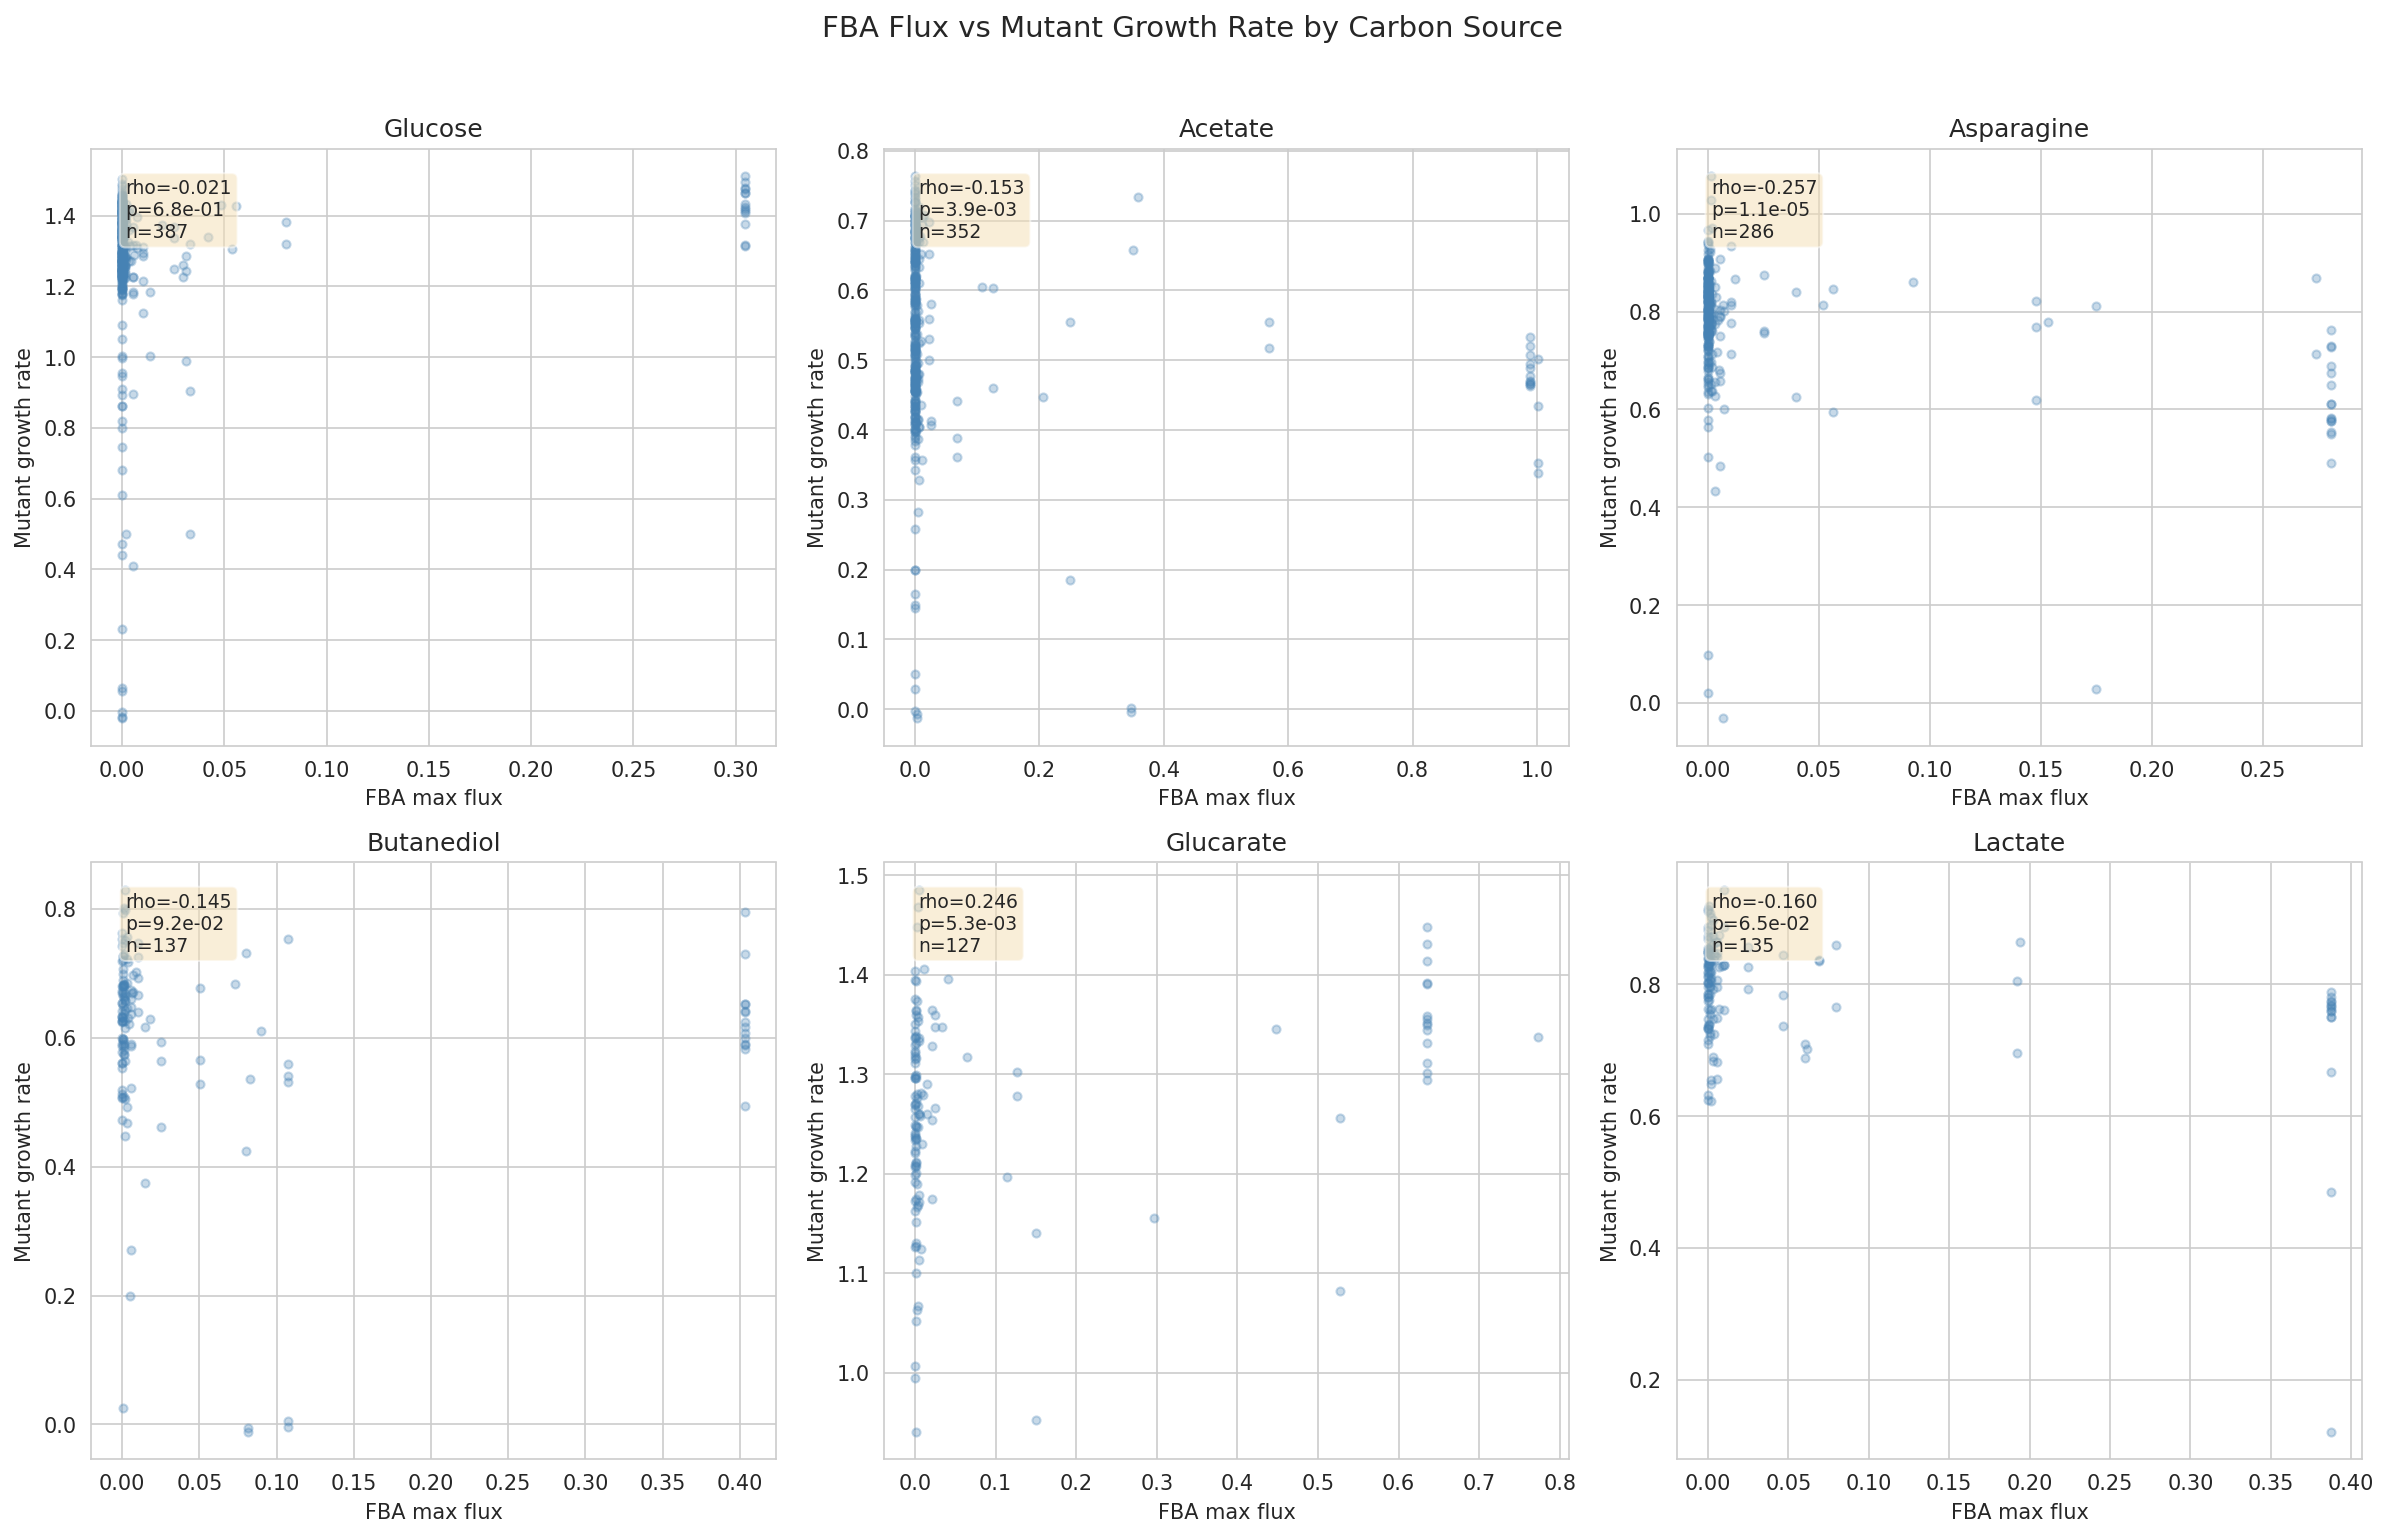

In [11]:
# Scatter plots: FBA flux vs growth rate for each matched condition
n_conds = len(matched_conditions)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, cond in enumerate(matched_conditions):
    flux_col = f'fba_flux_{cond}'
    growth_col = f'mutant_growth_{cond}'
    ax = axes[i]

    mask = triple[flux_col].notna() & triple[growth_col].notna()
    x = triple.loc[mask, flux_col]
    y = triple.loc[mask, growth_col]

    ax.scatter(x, y, alpha=0.3, s=15, c='steelblue')

    # Add Spearman rho annotation
    row = corr_df[corr_df['condition'] == cond].iloc[0]
    rho_str = f"rho={row['spearman_rho']:.3f}" if pd.notna(row['spearman_rho']) else 'N/A'
    p_str = f"p={row['p_value']:.1e}" if pd.notna(row['p_value']) else ''
    ax.text(0.05, 0.95, f'{rho_str}\n{p_str}\nn={row["n_genes"]:.0f}',
            transform=ax.transAxes, va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(cond.capitalize(), fontsize=12)
    ax.set_xlabel('FBA max flux')
    ax.set_ylabel('Mutant growth rate')

plt.suptitle('FBA Flux vs Mutant Growth Rate by Carbon Source', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'flux_vs_growth_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Condition-specific discordance: genes with growth defect on one condition
# but not another — does FBA predict this condition-specificity?
print('Condition-specific growth defects:')
defect_matrix = pd.DataFrame()
for cond in condition_names:
    col = f'growth_defect_{cond}'
    defect_matrix[cond] = triple[col]

# How many conditions does each gene have a defect on?
n_defect_conditions = defect_matrix.sum(axis=1)
print(f'\nGenes by number of conditions with growth defect:')
print(n_defect_conditions.value_counts().sort_index())

# Condition-specificity index: 1 = defect on only one condition, 0 = all or none
n_measured = defect_matrix.notna().sum(axis=1)
specificity = n_defect_conditions / n_measured
print(f'\nMean specificity (fraction of conditions with defect): {specificity.mean():.3f}')
print(f'Genes with defect on ALL measured conditions: {(specificity == 1.0).sum()}')
print(f'Genes with defect on NO conditions: {(specificity == 0.0).sum()}')
print(f'Genes with condition-specific defects (0 < spec < 1): '
      f'{((specificity > 0) & (specificity < 1)).sum()}')

Condition-specific growth defects:

Genes by number of conditions with growth defect:
0    135
1    103
2     81
3     67
4     39
5     26
6     18
7      7
8      2
Name: count, dtype: int64

Mean specificity (fraction of conditions with defect): 0.257
Genes with defect on ALL measured conditions: 10
Genes with defect on NO conditions: 135
Genes with condition-specific defects (0 < spec < 1): 333


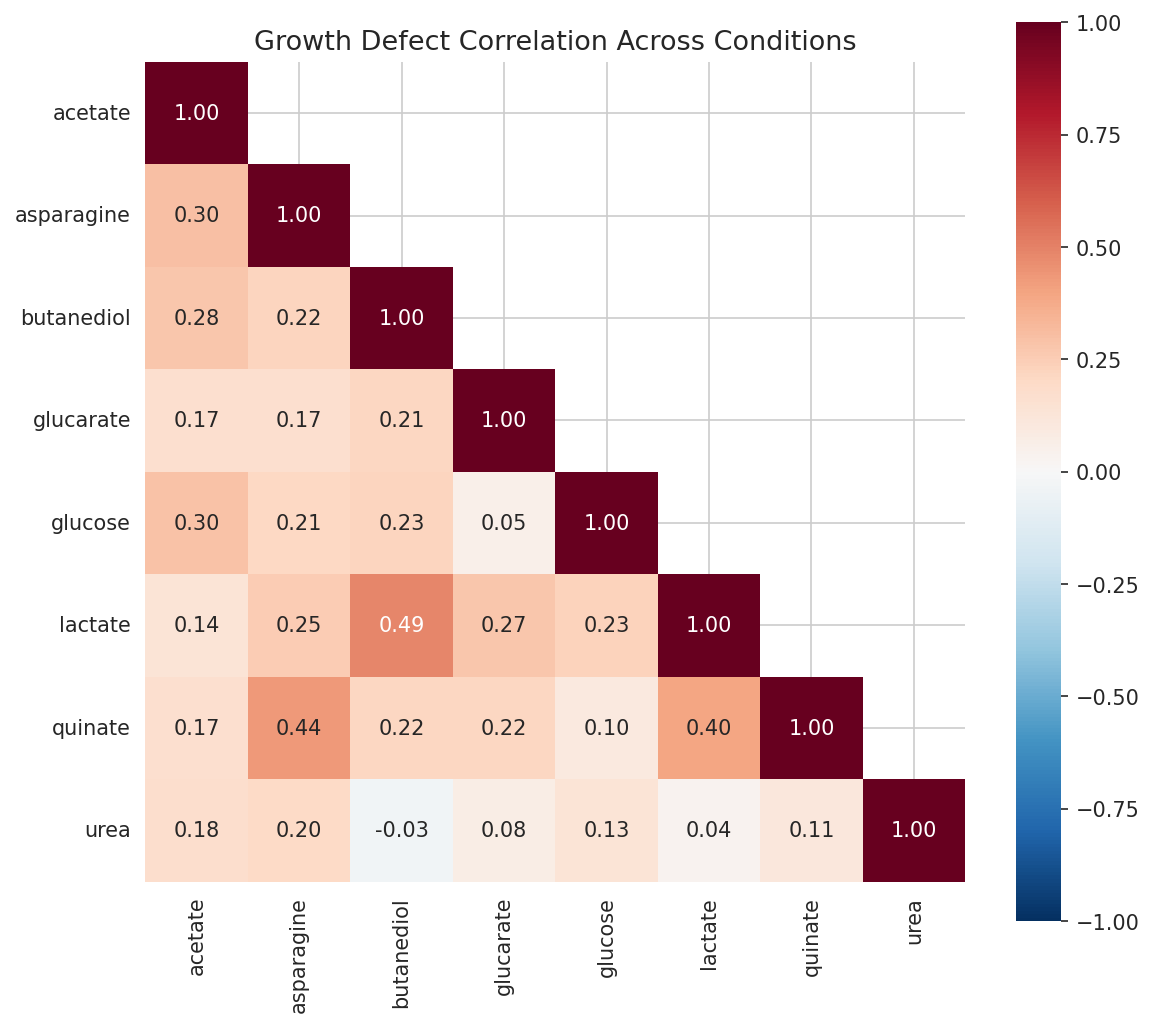

Mean pairwise defect correlation: 0.382
Range: -0.032 to 1.000


In [13]:
# Inter-condition growth defect correlation
defect_corr = defect_matrix.astype(float).corr()

fig, ax = plt.subplots(figsize=(8, 7))
mask = np.triu(np.ones_like(defect_corr, dtype=bool), k=1)
sns.heatmap(defect_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, mask=mask, ax=ax, square=True)
ax.set_title('Growth Defect Correlation Across Conditions', fontsize=13)
plt.tight_layout()
plt.savefig(FIG_DIR / 'defect_condition_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

upper = defect_corr.where(~mask).stack()
print(f'Mean pairwise defect correlation: {upper.mean():.3f}')
print(f'Range: {upper.min():.3f} to {upper.max():.3f}')

## 4. Summary Statistics

In [14]:
# Summary
print('='*60)
print('CONCORDANCE ANALYSIS SUMMARY')
print('='*60)
print(f'\nTriple-covered genes: {len(triple)}')
print(f'  All TnSeq-dispensable (by definition)')
print(f'  FBA-essential: {(triple["minimal_media_class"]=="essential").sum()}')
print(f'  FBA-variable: {(triple["minimal_media_class"]=="variable").sum()}')
print(f'  FBA-blocked: {(triple["minimal_media_class"]=="blocked").sum()}')

print(f'\nGrowth defect rate by FBA class:')
for c in ['essential', 'variable', 'blocked']:
    mask = triple['minimal_media_class'] == c
    rate = triple.loc[mask, 'any_growth_defect'].mean() * 100
    print(f'  {c:>10}: {rate:.1f}%')

print(f'\nChi-squared test: chi2={chi2:.2f}, p={p_value:.4f}')

print(f'\nCondition-specific FBA-growth correlations (Spearman):')
for _, row in corr_df.iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else 'ns'
    print(f'  {row["condition"]:>12}: rho={row["spearman_rho"]:.3f} ({sig}, n={row["n_genes"]:.0f})')

print(f'\nKey finding: FBA class is '
      + ('significantly' if p_value < 0.05 else 'not significantly')
      + f' associated with growth defect status (p={p_value:.4f})')

CONCORDANCE ANALYSIS SUMMARY

Triple-covered genes: 478
  All TnSeq-dispensable (by definition)
  FBA-essential: 78
  FBA-variable: 204
  FBA-blocked: 196

Growth defect rate by FBA class:
   essential: 73.1%
    variable: 73.5%
     blocked: 69.4%

Chi-squared test: chi2=0.93, p=0.6293

Condition-specific FBA-growth correlations (Spearman):
       glucose: rho=-0.021 (ns, n=387)
       acetate: rho=-0.153 (**, n=352)
    asparagine: rho=-0.257 (***, n=286)
    butanediol: rho=-0.145 (ns, n=137)
     glucarate: rho=0.246 (**, n=127)
       lactate: rho=-0.160 (ns, n=135)

Key finding: FBA class is not significantly associated with growth defect status (p=0.6293)
